# Mini Projet SSL for Anomaly Detection

In [1]:
# Imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms.functional import rgb_to_grayscale
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
import PIL
from PIL import Image
import random
import opendatasets as od
import os
from time import time
import multiprocessing as mp
import numpy as np
from pathlib import Path

In [ ]:
# Create a directory to store the datasets
os.makedirs("datasets", exist_ok=True)

mvtec_ad_url = "https://www.kaggle.com/datasets/ipythonx/mvtec-ad"
auto_vi_url = "https://zenodo.org/api/records/10459003/files-archive"

od.download(mvtec_ad_url, data_dir="datasets/MVTec_AD")

od.download(auto_vi_url, data_dir="datasets/AutoVI")
!unzip datasets/AutoVI/10459003.zip -d datasets/AutoVI
!unzip datasets/AutoVI/engine_wiring.zip -d datasets/AutoVI

### Global Variables

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRANSFORM = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

MVTEC_PATH = 'datasets/MVTec_AD/mvtec-ad'
AUTOVI_PATH = 'datasets/AutoVI/engine_wiring'
CATEGORIES_MVTEC = ['bottle', 'hazelnut', 'capsule', 'toothbrush']
CATEGORIES_AUTOVI = ['blue_hoop', 'cardboard', 'fastening', 'obstruction']

### Chargement et prétraitement des images de MVTec AD

In [3]:
CATEGORIES_MVTEC = ['bottle', 'hazelnut', 'capsule', 'toothbrush']
MVTEC_PATH = 'datasets/MVTec_AD/mvtec-ad'

def load_mvtec_images(category, split='train'):
    images = []
    labels = []
    
    split_path = os.path.join(MVTEC_PATH, category, split)
    
    if split == 'train':
        good_path = os.path.join(split_path, 'good')
        for img_name in os.listdir(good_path):
            img_path = os.path.join(good_path, img_name)
            img = Image.open(img_path).convert('RGB')
            img = TRANSFORM(img)
            images.append(img)
            labels.append(0)
    else:
        for anomaly_type in os.listdir(split_path):
            anomaly_path = os.path.join(split_path, anomaly_type)
            for img_name in os.listdir(anomaly_path):
                img_path = os.path.join(anomaly_path, img_name)
                img = Image.open(img_path).convert('RGB')
                img = TRANSFORM(img)
                images.append(img)
                if anomaly_type == 'good':
                    labels.append(0)
                else:
                    labels.append(1)

    return torch.stack(images), torch.tensor(labels)

dataloaders_mvtec = {}

for category in CATEGORIES_MVTEC:
    # Load training data
    train_images, train_labels = load_mvtec_images(category, split='train')
    train_dataloader = DataLoader(
        list(zip(train_images, train_labels)), batch_size=16, shuffle=True
    )
    
    # Load testing data
    test_images, test_labels = load_mvtec_images(category, split='test')
    test_dataloader = DataLoader(
        list(zip(test_images, test_labels)), batch_size=16, shuffle=False
    )
    
    # Store dataloaders in a dictionary
    dataloaders_mvtec[category] = {
        'train': train_dataloader,
        'test': test_dataloader
    }


bottle_train_dataloader = dataloaders_mvtec['bottle']['train']
bottle_test_dataloader = dataloaders_mvtec['bottle']['test']

hazelnut_train_dataloader = dataloaders_mvtec['hazelnut']['train']
hazelnut_test_dataloader = dataloaders_mvtec['hazelnut']['test']

capsule_train_dataloader = dataloaders_mvtec['capsule']['train']
capsule_test_dataloader = dataloaders_mvtec['capsule']['test']

toothbrush_train_dataloader = dataloaders_mvtec['toothbrush']['train']
toothbrush_test_dataloader = dataloaders_mvtec['toothbrush']['test']

# Print summary
for category in CATEGORIES_MVTEC:
    print(f"Category: {category}")
    train_len = len(dataloaders_mvtec[category]['train'].dataset)
    test_len = len(dataloaders_mvtec[category]['test'].dataset)
    print(f"  Train set size: {train_len} images")
    print(f"  Test set size: {test_len} images")


Category: bottle
  Train set size: 209 images
  Test set size: 83 images
Category: hazelnut
  Train set size: 391 images
  Test set size: 110 images
Category: capsule
  Train set size: 219 images
  Test set size: 132 images
Category: toothbrush
  Train set size: 60 images
  Test set size: 42 images


### Chargement et prétraitement des images de AutoVI

In [4]:
# Function to load images from a specific split (train or test)
def load_autovi_images(split='train'):
    images = []
    labels = []
    
    # Define the path based on the split (train/test)
    split_path = os.path.join(AUTOVI_PATH, split)
    
    # List all subfolders (categories)
    categories = os.listdir(split_path)
    
    for category in categories:
        category_path = os.path.join(split_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path).convert('RGB')  
            img = TRANSFORM(img)  
            images.append(img)
            
            # Use the index of the category as a label (you can adjust this if needed)
            labels.append(categories.index(category))
    
    return torch.stack(images), torch.tensor(labels)  

# Load AutoVI dataset images (train and test)
train_images, train_labels = load_autovi_images(split='train')
test_images, test_labels = load_autovi_images(split='test')

# Create DataLoaders for AutoVI train and test sets
train_dataloader_auto = DataLoader(list(zip(train_images, train_labels)), batch_size=16, shuffle=True)
test_dataloader_auto = DataLoader(list(zip(test_images, test_labels)), batch_size=16, shuffle=False)

# Check loaded data
print(f"Loaded {len(train_images)} training images and {len(test_images)} test images from AutoVI.")

Loaded 285 training images and 607 test images from AutoVI.


### Visualisation

In [5]:
def denormalize(tensor):
    denormalized_tensor = tensor * 0.5 + 0.5
    return denormalized_tensor

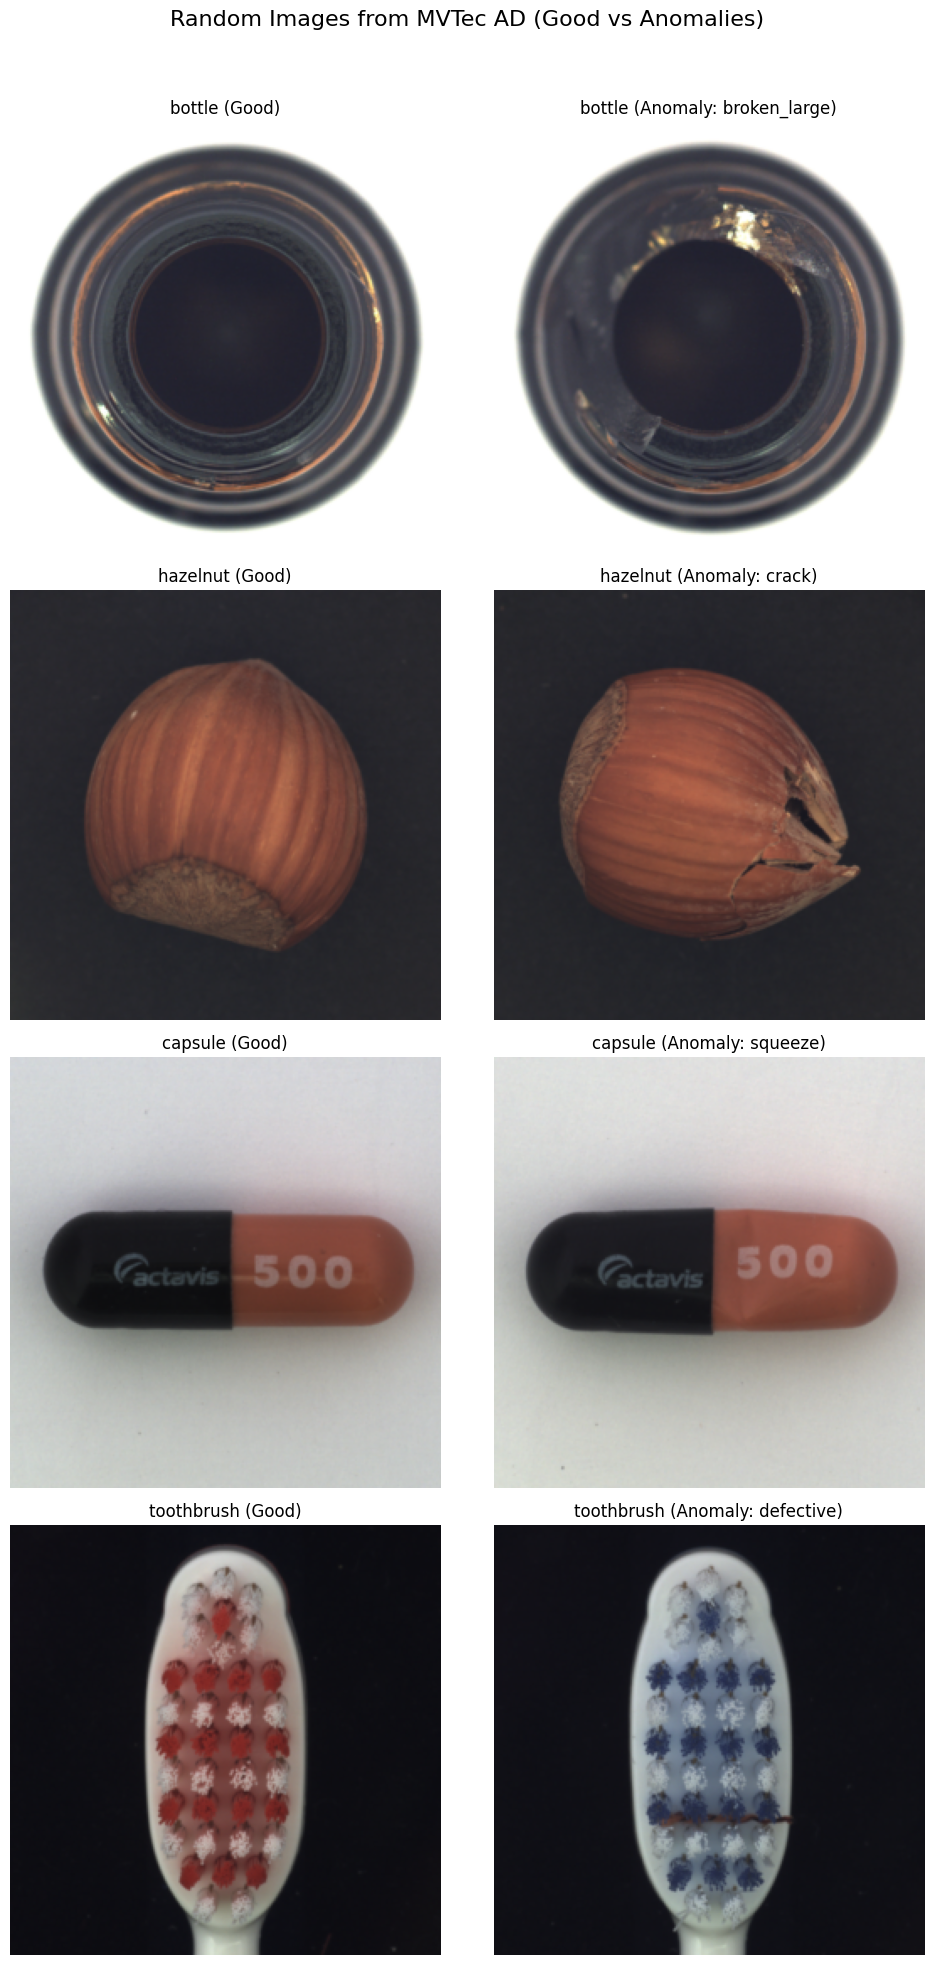

In [6]:
def display_random__MVTec(category_list, dataset_name, dataset_path, transform, split='test'):
    fig, axs = plt.subplots(len(category_list), 2, figsize=(10, 5 * len(category_list)))  
    fig.suptitle(f'Random Images from {dataset_name} (Good vs Anomalies)', fontsize=16)
    
    for i, category in enumerate(category_list):
        # Path for the test split
        split_path = os.path.join(dataset_path, category, split)
        
        # Load a random "good" image
        good_path = os.path.join(split_path, 'good')
        good_image = random.choice(os.listdir(good_path))
        good_image_path = os.path.join(good_path, good_image)
        img_good = Image.open(good_image_path).convert('RGB')
        img_good = transform(img_good)
        
        # Display the "good" image
        img_good = denormalize(img_good)
        axs[i, 0].imshow(np.clip(img_good.permute(1, 2, 0).numpy(), 0, 1))  # Convert to NumPy and clip
        axs[i, 0].set_title(f"{category} (Good)")
        axs[i, 0].axis('off')
        
        # Load a random anomalous image (choose a random anomaly type)
        anomalies = [d for d in os.listdir(split_path) if d != 'good']
        anomaly_type = random.choice(anomalies)
        anomaly_path = os.path.join(split_path, anomaly_type)
        anomaly_image = random.choice(os.listdir(anomaly_path))
        anomaly_image_path = os.path.join(anomaly_path, anomaly_image)
        img_anomalous = Image.open(anomaly_image_path).convert('RGB')
        img_anomalous = transform(img_anomalous)
        
        # Display the anomalous image
        img_anomalous = denormalize(img_anomalous)
        axs[i, 1].imshow(np.clip(img_anomalous.permute(1, 2, 0).numpy(), 0, 1))  # Convert to NumPy and clip
        axs[i, 1].set_title(f"{category} (Anomaly: {anomaly_type})")
        axs[i, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage for MVTec AD dataset
display_random__MVTec(CATEGORIES_MVTEC, "MVTec AD", MVTEC_PATH, TRANSFORM, split='test')

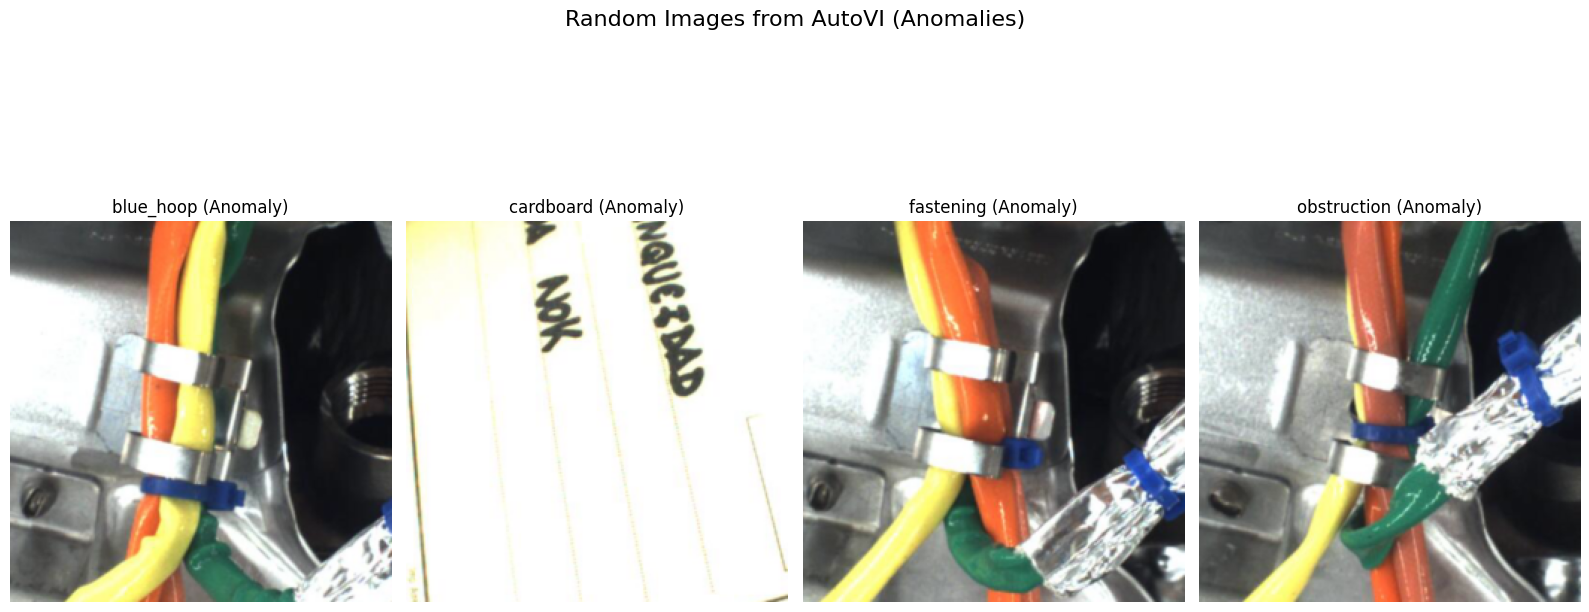

In [7]:
def display_random_autovi(category_list, dataset_name, dataset_path, transform, split='test'):
    fig, axs = plt.subplots(1, len(category_list), figsize=(16, 8))  # Create subplot (1 row, 1 column per category)
    fig.suptitle(f'Random Images from {dataset_name} (Anomalies)', fontsize=16)
    
    for i, category in enumerate(category_list):
        # Path for the test split
        split_path = os.path.join(dataset_path, split, category)
        
        # Load a random anomalous image
        anomaly_image = random.choice(os.listdir(split_path))
        anomaly_image_path = os.path.join(split_path, anomaly_image)
        img_anomalous = Image.open(anomaly_image_path).convert('RGB')
        img_anomalous = transform(img_anomalous)
        
        # Display the anomalous image
        img_anomalous = denormalize(img_anomalous)
        axs[i].imshow(np.clip(img_anomalous.permute(1, 2, 0).numpy(), 0, 1))  # Rearrange dimensions for display
        axs[i].set_title(f"{category} (Anomaly)")
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage for AutoVI dataset
display_random_autovi(CATEGORIES_AUTOVI, "AutoVI", AUTOVI_PATH, TRANSFORM, split='test')

## Masked AutoEncoder

In [42]:
class Encoder(nn.Module):
    def __init__(self, latent_dim,in_channels):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.encode(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1), 
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

In [43]:
# Define the Masked Autoencoder model
class MaskedAutoencoder(nn.Module):
    def __init__(self, mask_ratio, hidden_dim=1024):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim=hidden_dim, in_channels=3)  
        self.decoder = Decoder(latent_dim=hidden_dim, out_channels=3)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        masked_x = self.apply_mask(x)
        encoded = self.encoder(masked_x)
        decoded = self.decoder(encoded)
        return decoded.view(batch_size, channels, height, width)

    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)  
        x_masked[mask] = 0
        return x_masked


In [48]:
# Function to train the model
from tqdm import tqdm
def train_model(model, dataloader, epochs, lr=0.001):
    criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for images, _ in tqdm(dataloader):
            images = images.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

# Function to evaluate the model and calculate ROC-AUC
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.MSELoss(reduction='none')  # Use reduction='none' to compute loss per pixel
    losses = []
    labels = []
    seuil = 0.5
    with torch.no_grad():
        for images, lbls in tqdm(dataloader):
            images = images.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, images).mean(dim=[1, 2, 3])  # Mean loss over pixels
            losses.extend(loss.cpu().numpy())
            binary_labels = [1 if label != 0 else 0 for label in lbls]
            labels.extend(binary_labels)
            
    # Appliquer le seuil pour classifier les images
    predicted_labels = [1 if loss > seuil else 0 for loss in losses]
    print(losses)
    inverted_losses = [1.0 / loss for loss in losses]
    print(inverted_losses)
    fpr, tpr, thresholds = roc_curve(labels, inverted_losses)

    #accuracy = accuracy_score(labels, predicted_labels)
    #print(f"Accuracy with threshold {seuil}: {accuracy:.4f}")
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Masked Autoencoder')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

### MAE for bottle

In [128]:
# Initialize and train the model
mae_bottle_MV = MaskedAutoencoder(mask_ratio = 1/3).to(DEVICE)
train_model(mae_bottle_MV, bottle_train_dataloader, epochs=15)
torch.save(mae_bottle_MV.state_dict(), 'Masked_Autoencoder_bottle_weights.pth')


100%|██████████| 14/14 [00:01<00:00, 13.46it/s]


Epoch [1/15], Loss: 0.5362


100%|██████████| 14/14 [00:00<00:00, 14.86it/s]


Epoch [2/15], Loss: 0.3477


100%|██████████| 14/14 [00:00<00:00, 14.71it/s]


Epoch [3/15], Loss: 0.2310


100%|██████████| 14/14 [00:00<00:00, 14.68it/s]


Epoch [4/15], Loss: 0.1752


100%|██████████| 14/14 [00:00<00:00, 14.73it/s]


Epoch [5/15], Loss: 0.1690


100%|██████████| 14/14 [00:00<00:00, 14.67it/s]


Epoch [6/15], Loss: 0.1665


100%|██████████| 14/14 [00:00<00:00, 14.68it/s]


Epoch [7/15], Loss: 0.1662


100%|██████████| 14/14 [00:00<00:00, 14.59it/s]


Epoch [8/15], Loss: 0.1657


100%|██████████| 14/14 [00:00<00:00, 14.53it/s]


Epoch [9/15], Loss: 0.1651


100%|██████████| 14/14 [00:00<00:00, 14.58it/s]


Epoch [10/15], Loss: 0.1646


100%|██████████| 14/14 [00:00<00:00, 14.62it/s]


Epoch [11/15], Loss: 0.1652


100%|██████████| 14/14 [00:00<00:00, 14.56it/s]


Epoch [12/15], Loss: 0.1651


100%|██████████| 14/14 [00:00<00:00, 14.70it/s]


Epoch [13/15], Loss: 0.1650


100%|██████████| 14/14 [00:00<00:00, 14.71it/s]


Epoch [14/15], Loss: 0.1646


100%|██████████| 14/14 [00:00<00:00, 14.59it/s]

Epoch [15/15], Loss: 0.1646


100%|██████████| 6/6 [00:00<00:00, 16.60it/s]

[0.15421821, 0.1709561, 0.15951382, 0.18573974, 0.15812635, 0.15316054, 0.16148803, 0.15952957, 0.16512844, 0.15963301, 0.16272944, 0.16489911, 0.14871542, 0.14723651, 0.15922071, 0.15925597, 0.15314618, 0.15803722, 0.16852443, 0.15111119, 0.16261348, 0.15799335, 0.15441413, 0.15578431, 0.16025144, 0.16052869, 0.1621151, 0.15817282, 0.1584878, 0.15926433, 0.16446576, 0.16157082, 0.16373792, 0.16309093, 0.16087618, 0.1670939, 0.16115315, 0.15198967, 0.16355966, 0.16709094, 0.1547969, 0.15123682, 0.15796004, 0.15373975, 0.16485971, 0.16728786, 0.16592072, 0.13339232, 0.10122976, 0.16587877, 0.15625349, 0.16332754, 0.15540865, 0.13539231, 0.11088067, 0.17292905, 0.16105056, 0.15841576, 0.13682172, 0.1751461, 0.16378167, 0.15463066, 0.1254979, 0.16572885, 0.16384329, 0.1573377, 0.16121274, 0.16504177, 0.15525454, 0.1516069, 0.1591128, 0.1638591, 0.16766736, 0.1674479, 0.15721904, 0.15901929, 0.14813012, 0.15904614, 0.16183183, 0.15600985, 0.15712672, 0.16727704, 0.15802085]
[6.484318476542

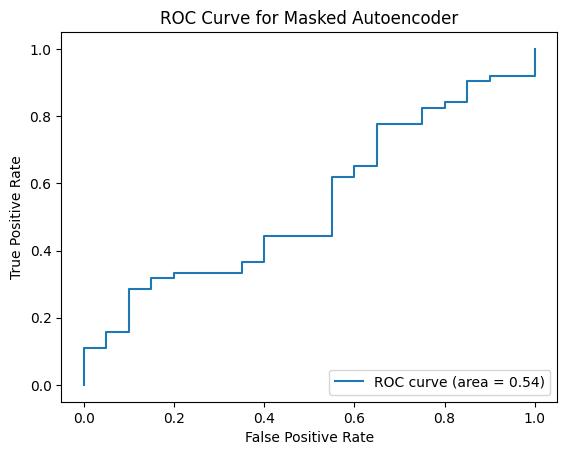

AUROC Score: 0.5405


In [129]:
# Evaluate the model
roc_auc = evaluate_model(mae_bottle_MV, bottle_test_dataloader)
print(f"AUROC Score: {roc_auc:.4f}")

### MAE for hazelnut

In [130]:
# Initialize and train the model
mae_hazelnut_MV = MaskedAutoencoder(mask_ratio = 1/12).to(DEVICE)
train_model(mae_hazelnut_MV, hazelnut_train_dataloader, epochs=15)
torch.save(mae_hazelnut_MV.state_dict(), 'Masked_Autoencoder_hazelnut_weights.pth')


100%|██████████| 25/25 [00:01<00:00, 12.95it/s]


Epoch [1/15], Loss: 0.5162


100%|██████████| 25/25 [00:01<00:00, 14.07it/s]


Epoch [2/15], Loss: 0.4219


100%|██████████| 25/25 [00:01<00:00, 14.16it/s]


Epoch [3/15], Loss: 0.4211


100%|██████████| 25/25 [00:01<00:00, 14.16it/s]


Epoch [4/15], Loss: 0.4207


100%|██████████| 25/25 [00:01<00:00, 14.07it/s]


Epoch [5/15], Loss: 0.4207


100%|██████████| 25/25 [00:01<00:00, 14.13it/s]


Epoch [6/15], Loss: 0.4210


100%|██████████| 25/25 [00:01<00:00, 14.22it/s]


Epoch [7/15], Loss: 0.4212


100%|██████████| 25/25 [00:01<00:00, 14.26it/s]


Epoch [8/15], Loss: 0.4209


100%|██████████| 25/25 [00:01<00:00, 14.20it/s]


Epoch [9/15], Loss: 0.4206


100%|██████████| 25/25 [00:01<00:00, 14.20it/s]


Epoch [10/15], Loss: 0.4210


100%|██████████| 25/25 [00:01<00:00, 14.24it/s]


Epoch [11/15], Loss: 0.4207


100%|██████████| 25/25 [00:01<00:00, 14.21it/s]


Epoch [12/15], Loss: 0.4207


100%|██████████| 25/25 [00:01<00:00, 14.17it/s]


Epoch [13/15], Loss: 0.4205


100%|██████████| 25/25 [00:01<00:00, 14.19it/s]


Epoch [14/15], Loss: 0.4211


100%|██████████| 25/25 [00:01<00:00, 14.28it/s]


Epoch [15/15], Loss: 0.4209


100%|██████████| 7/7 [00:00<00:00, 21.10it/s]


[0.38530955, 0.39808816, 0.36841068, 0.3964588, 0.37637496, 0.39727056, 0.38282487, 0.38202804, 0.39523587, 0.40287042, 0.39418957, 0.3867736, 0.39118332, 0.39343756, 0.37476057, 0.37973723, 0.37193057, 0.40977824, 0.35729933, 0.37062132, 0.3723104, 0.38206968, 0.3716215, 0.37494978, 0.39279306, 0.3893504, 0.36258507, 0.37834534, 0.38657105, 0.37587863, 0.36242503, 0.38527006, 0.38572425, 0.37283978, 0.3868174, 0.36613917, 0.3729113, 0.3767472, 0.3822863, 0.35603198, 0.3631158, 0.3698271, 0.37024137, 0.37531042, 0.38760838, 0.36961278, 0.37058362, 0.37677574, 0.37128258, 0.36982426, 0.37655658, 0.3629964, 0.36710936, 0.36544114, 0.36017692, 0.3743001, 0.37483168, 0.36522025, 0.355572, 0.36122227, 0.34727764, 0.36866266, 0.36995614, 0.35634583, 0.37432072, 0.36212954, 0.37730247, 0.35870504, 0.35918877, 0.38357514, 0.363657, 0.36371857, 0.37398338, 0.35703894, 0.35295278, 0.3917308, 0.39782667, 0.38588238, 0.39919752, 0.4017073, 0.4032981, 0.40025553, 0.3756966, 0.41052112, 0.4007694, 0

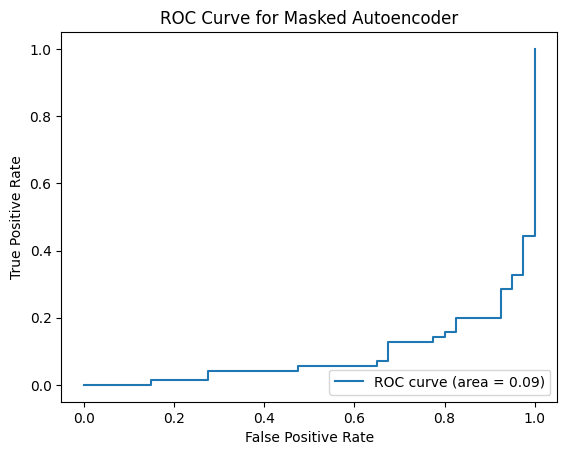

AUROC Score: 0.0889


In [131]:
# Evaluate the model
roc_auc = evaluate_model(mae_hazelnut_MV, hazelnut_test_dataloader)
print(f"AUROC Score: {roc_auc:.4f}")

### MAE for capsule

In [37]:
# Initialize and train the model
mae_capsule_MV = MaskedAutoencoder(mask_ratio = 0.25).to(DEVICE)
train_model(mae_capsule_MV, capsule_train_dataloader, epochs=15)
torch.save(mae_capsule_MV.state_dict(), 'Masked_Autoencoder_capsule_weights.pth')


100%|██████████| 14/14 [00:01<00:00, 10.22it/s]


Epoch [1/15], Loss: 0.1799


100%|██████████| 14/14 [00:00<00:00, 14.04it/s]


Epoch [2/15], Loss: 0.1032


100%|██████████| 14/14 [00:00<00:00, 14.21it/s]


Epoch [3/15], Loss: 0.0862


100%|██████████| 14/14 [00:00<00:00, 14.07it/s]


Epoch [4/15], Loss: 0.0838


100%|██████████| 14/14 [00:00<00:00, 14.12it/s]


Epoch [5/15], Loss: 0.0829


100%|██████████| 14/14 [00:01<00:00, 13.98it/s]


Epoch [6/15], Loss: 0.0824


100%|██████████| 14/14 [00:00<00:00, 14.03it/s]


Epoch [7/15], Loss: 0.0823


100%|██████████| 14/14 [00:00<00:00, 14.08it/s]


Epoch [8/15], Loss: 0.0819


100%|██████████| 14/14 [00:00<00:00, 14.09it/s]


Epoch [9/15], Loss: 0.0817


100%|██████████| 14/14 [00:00<00:00, 14.15it/s]


Epoch [10/15], Loss: 0.0817


100%|██████████| 14/14 [00:00<00:00, 14.07it/s]


Epoch [11/15], Loss: 0.0818


100%|██████████| 14/14 [00:00<00:00, 14.13it/s]


Epoch [12/15], Loss: 0.0819


100%|██████████| 14/14 [00:01<00:00, 13.91it/s]


Epoch [13/15], Loss: 0.0816


100%|██████████| 14/14 [00:00<00:00, 14.00it/s]


Epoch [14/15], Loss: 0.0812


100%|██████████| 14/14 [00:00<00:00, 14.12it/s]


Epoch [15/15], Loss: 0.0811


100%|██████████| 9/9 [00:00<00:00, 19.65it/s]


[0.08251381, 0.07635425, 0.07630785, 0.08303568, 0.0814002, 0.081705436, 0.07787619, 0.08127963, 0.08087656, 0.07732041, 0.07325225, 0.07590987, 0.08175194, 0.08122583, 0.07966593, 0.08128035, 0.08011183, 0.081243396, 0.07951349, 0.08165726, 0.08288343, 0.0792694, 0.084194034, 0.08125793, 0.08144048, 0.080499254, 0.08268057, 0.081906036, 0.08179599, 0.07687608, 0.08114882, 0.08245857, 0.08369329, 0.07646932, 0.076591775, 0.07996635, 0.07979857, 0.07561912, 0.075329386, 0.078289896, 0.07855529, 0.07769924, 0.07760739, 0.07768531, 0.08251209, 0.08347927, 0.083110854, 0.07987665, 0.08095077, 0.09172216, 0.07785295, 0.07307218, 0.07144136, 0.090295695, 0.09284681, 0.085333005, 0.07688665, 0.08426183, 0.080922656, 0.07865888, 0.085220955, 0.0853815, 0.08569063, 0.08316971, 0.09013376, 0.08138028, 0.08041549, 0.08128442, 0.085201964, 0.08386471, 0.08241935, 0.08312285, 0.08044073, 0.08040522, 0.07948819, 0.080607936, 0.07986996, 0.080713674, 0.08154556, 0.081593215, 0.078785926, 0.079178825,

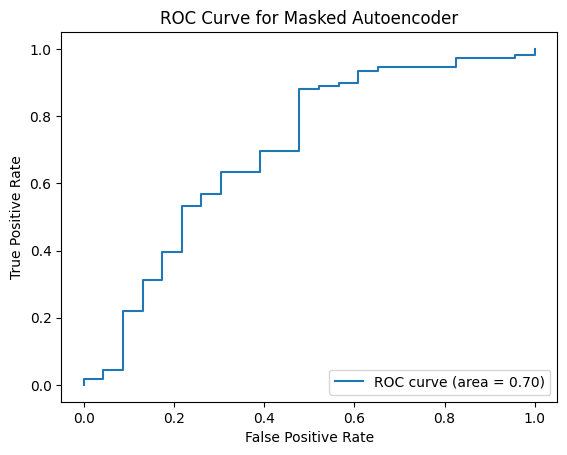

AUROC Score: 0.6972


In [49]:
# Evaluate the model
roc_auc = evaluate_model(mae_capsule_MV, capsule_test_dataloader)
print(f"AUROC Score: {roc_auc:.4f}")

### MAE for toothbrush

In [46]:
# Initialize and train the model
mae_toothbrush_MV = MaskedAutoencoder(mask_ratio = 1/3).to(DEVICE)
train_model(mae_toothbrush_MV, toothbrush_train_dataloader, epochs=15)
torch.save(mae_toothbrush_MV.state_dict(), 'Masked_Autoencoder_toothbrush_weights.pth')


100%|██████████| 4/4 [00:00<00:00,  8.17it/s]


Epoch [1/15], Loss: 1.1435


100%|██████████| 4/4 [00:00<00:00, 14.90it/s]


Epoch [2/15], Loss: 0.5695


100%|██████████| 4/4 [00:00<00:00, 14.52it/s]


Epoch [3/15], Loss: 0.5652


100%|██████████| 4/4 [00:00<00:00, 14.77it/s]


Epoch [4/15], Loss: 0.5637


100%|██████████| 4/4 [00:00<00:00, 14.93it/s]


Epoch [5/15], Loss: 0.5613


100%|██████████| 4/4 [00:00<00:00, 14.95it/s]


Epoch [6/15], Loss: 0.5608


100%|██████████| 4/4 [00:00<00:00, 14.96it/s]


Epoch [7/15], Loss: 0.5598


100%|██████████| 4/4 [00:00<00:00, 14.85it/s]


Epoch [8/15], Loss: 0.5607


100%|██████████| 4/4 [00:00<00:00, 14.43it/s]


Epoch [9/15], Loss: 0.5595


100%|██████████| 4/4 [00:00<00:00, 14.95it/s]


Epoch [10/15], Loss: 0.5600


100%|██████████| 4/4 [00:00<00:00, 14.96it/s]


Epoch [11/15], Loss: 0.5599


100%|██████████| 4/4 [00:00<00:00, 14.89it/s]


Epoch [12/15], Loss: 0.5597


100%|██████████| 4/4 [00:00<00:00, 14.58it/s]


Epoch [13/15], Loss: 0.5601


100%|██████████| 4/4 [00:00<00:00, 14.67it/s]


Epoch [14/15], Loss: 0.5598


100%|██████████| 4/4 [00:00<00:00, 14.83it/s]


Epoch [15/15], Loss: 0.5601


100%|██████████| 3/3 [00:00<00:00, 19.90it/s]


[0.5457496, 0.54099435, 0.54548025, 0.54829186, 0.54287076, 0.53901577, 0.54310775, 0.545176, 0.5407913, 0.5529432, 0.637926, 0.61285514, 0.6085388, 0.608588, 0.5932687, 0.59236443, 0.6159137, 0.58809966, 0.61891335, 0.61566997, 0.5281815, 0.52932566, 0.5243875, 0.5243251, 0.52909964, 0.5235163, 0.5288532, 0.5281467, 0.5317997, 0.52761686, 0.55912507, 0.55189323, 0.5506794, 0.5595139, 0.5832896, 0.58427346, 0.5859233, 0.5861293, 0.532199, 0.53204584, 0.5335301, 0.5309165]
[1.8323421425949462, 1.8484481531676895, 1.8332469371609896, 1.8238461470727032, 1.8420590566829091, 1.8552332895139587, 1.841255264032408, 1.834269935634649, 1.8491422656214525, 1.808503922884152, 1.56757998180259, 1.6317069738260142, 1.6432805754042745, 1.643147798541332, 1.685576893999104, 1.6881499776720714, 1.6236041147290845, 1.7003920773715562, 1.615735055606207, 1.624246845940471, 1.8932886000712077, 1.8891961375180153, 1.906986799597443, 1.9072137724139069, 1.8900031644218498, 1.9101602091095833, 1.8908839760

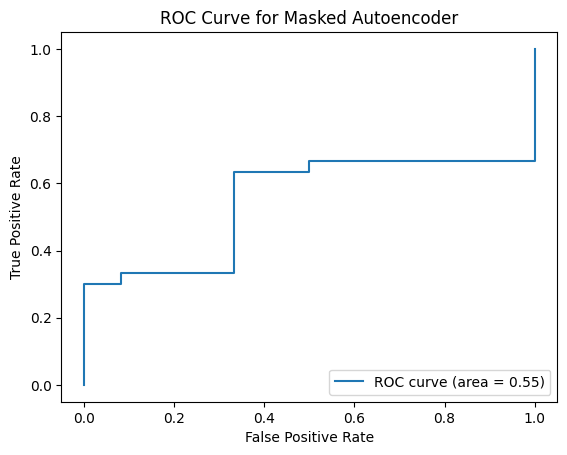

AUROC Score: 0.5472


In [50]:
# Evaluate the model
roc_auc = evaluate_model(mae_toothbrush_MV, toothbrush_test_dataloader)
print(f"AUROC Score: {roc_auc:.4f}")

### MAE for engine AutoVI 

In [54]:
# Assuming train_dataloader_MVTec and test_dataloader_MVTec are defined
# Initialize and train the model
mae_model_auto = MaskedAutoencoder(mask_ratio = 1/5).to(DEVICE)
train_model(mae_model_auto, train_dataloader_auto, epochs=15)
torch.save(mae_model_auto.state_dict(), 'Masked_Autoencoder_AUTO_weights.pth')



100%|██████████| 18/18 [00:01<00:00, 10.65it/s]


Epoch [1/15], Loss: 0.4579


100%|██████████| 18/18 [00:01<00:00, 14.00it/s]


Epoch [2/15], Loss: 0.4141


100%|██████████| 18/18 [00:01<00:00, 13.98it/s]


Epoch [3/15], Loss: 0.4141


100%|██████████| 18/18 [00:01<00:00, 13.90it/s]


Epoch [4/15], Loss: 0.4142


100%|██████████| 18/18 [00:01<00:00, 13.96it/s]


Epoch [5/15], Loss: 0.4097


100%|██████████| 18/18 [00:01<00:00, 13.97it/s]


Epoch [6/15], Loss: 0.3692


100%|██████████| 18/18 [00:01<00:00, 13.90it/s]


Epoch [7/15], Loss: 0.3036


100%|██████████| 18/18 [00:01<00:00, 13.78it/s]


Epoch [8/15], Loss: 0.2762


100%|██████████| 18/18 [00:01<00:00, 13.75it/s]


Epoch [9/15], Loss: 0.2515


100%|██████████| 18/18 [00:01<00:00, 13.80it/s]


Epoch [10/15], Loss: 0.2410


100%|██████████| 18/18 [00:01<00:00, 13.80it/s]


Epoch [11/15], Loss: 0.2338


100%|██████████| 18/18 [00:01<00:00, 13.86it/s]


Epoch [12/15], Loss: 0.2295


100%|██████████| 18/18 [00:01<00:00, 13.72it/s]


Epoch [13/15], Loss: 0.2268


100%|██████████| 18/18 [00:01<00:00, 13.80it/s]


Epoch [14/15], Loss: 0.2245


100%|██████████| 18/18 [00:01<00:00, 13.92it/s]


Epoch [15/15], Loss: 0.2228


100%|██████████| 38/38 [00:01<00:00, 29.99it/s]


[0.27092123, 0.2165753, 0.24050276, 0.22884236, 0.23437726, 0.040766113, 0.020449169, 0.03888997, 0.08149797, 0.16010247, 0.22720248, 0.22722447, 0.23122269, 0.24487323, 0.21304683, 0.21565539, 0.23741196, 0.23411697, 0.20070818, 0.21059752, 0.22953497, 0.24327569, 0.23642239, 0.21937524, 0.23676154, 0.21989611, 0.22782062, 0.2142003, 0.2384911, 0.2758327, 0.23309183, 0.25464764, 0.25859353, 0.2666274, 0.25104398, 0.24806713, 0.23864685, 0.25492156, 0.22640114, 0.22596787, 0.24836016, 0.2314956, 0.23783669, 0.20947604, 0.24827072, 0.23542641, 0.26377505, 0.25581968, 0.24899255, 0.25840005, 0.23760073, 0.26285443, 0.24860996, 0.25662977, 0.21283397, 0.24721655, 0.23197494, 0.25899908, 0.22072327, 0.25161862, 0.21463275, 0.23873219, 0.2094786, 0.23625109, 0.23218173, 0.27553183, 0.2317886, 0.2559914, 0.2596696, 0.2606696, 0.24614315, 0.26372558, 0.24485986, 0.23348403, 0.23055713, 0.25576475, 0.25272292, 0.27161288, 0.24236724, 0.25773585, 0.25149345, 0.27231774, 0.27715668, 0.23856542, 

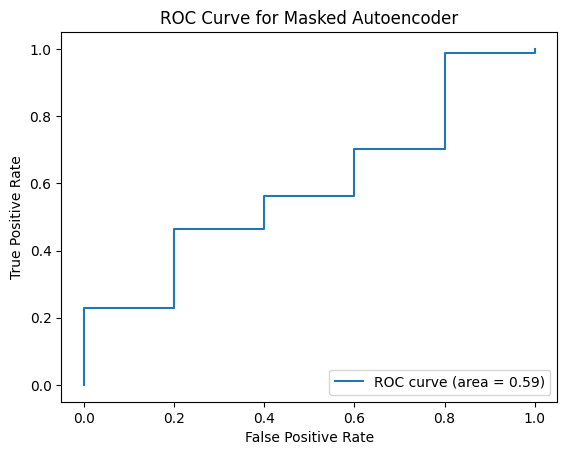

AUROC Score: 0.5887


In [55]:
# Evaluate the model
roc_aucs = evaluate_model(mae_model_auto, test_dataloader_auto)
print(f"AUROC Score: {roc_aucs:.4f}")

## Contrastive Model

In [118]:
class ContrastiveModel(nn.Module):
    def __init__(self):
        super(ContrastiveModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # (3, 256, 256) -> (16, 256, 256)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (16, 256, 256) -> (16, 128, 128)

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # (16, 128, 128) -> (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (32, 128, 128) -> (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (32, 64, 64) -> (64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (64, 64, 64) -> (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (64, 32, 32) -> (128, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # (128, 32, 32) -> (128, 16, 16)
        )
        
        # Taille de sortie de l'encodeur : (128, 16, 16)
        self.flatten_dim = 128 * 16 * 16
        self.fc = nn.Linear(self.flatten_dim, 128)  # Réduit à 128 dimensions

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir les données
        x = self.fc(x)
        return x

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, z1, z2, label):
        euclidean_distance = nn.functional.pairwise_distance(z1, z2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + 
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

In [117]:
import random
from torchvision import transforms

# Définir les augmentations
AUGMENTATIONS = transforms.Compose([
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip()
])

def generate_contrastive_pairs_with_augmentation(batch_images, batch_labels):
    pairs = []
    pair_labels = []

    batch_size = len(batch_images)

    for i in range(batch_size):
        # Générer une paire positive (image et sa transformation "légère")
        positive_image = AUGMENTATIONS(batch_images[i])  # Transformation
        pairs.append((batch_images[i], positive_image))
        pair_labels.append(1)  # 1 pour paire positive

        # Générer une paire négative avec augmentation
        negative_image = AUGMENTATIONS(batch_images[i])  # Transformation forte
        pairs.append((batch_images[i], negative_image))
        pair_labels.append(0)  # 0 pour paire négative

    # Convertir en tenseurs
    pair1, pair2 = zip(*pairs)
    return (torch.stack(pair1), torch.stack(pair2)), torch.tensor(pair_labels)


In [116]:
def train_contrastive_model(model, dataloader, epochs, lr=7e-4):
    criterion = ContrastiveLoss(margin=1.0)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for batch_images, batch_labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch_images = batch_images.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            
            # Génération des paires avec augmentation
            pairs, pair_labels = generate_contrastive_pairs_with_augmentation(batch_images, batch_labels)

            # Encodage des paires
            z1 = model(pairs[0].to(DEVICE))
            z2 = model(pairs[1].to(DEVICE))

            optimizer.zero_grad()
            loss = criterion(z1, z2, pair_labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_images.size(0)
        
        avg_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


In [92]:
def evaluate_contrastive_model(model, dataloader):
    model.eval()
    distances = []
    labels = []
    with torch.no_grad():
        for batch_images, batch_labels in tqdm(dataloader):
            pairs, pair_labels = generate_contrastive_pairs_with_augmentation(batch_images, batch_labels)
            z1 = model(pairs[0].to(DEVICE))
            z2 = model(pairs[1].to(DEVICE))
            euclidean_distance = nn.functional.pairwise_distance(z1, z2)
            distances.extend(euclidean_distance.cpu().numpy())
            labels.extend(pair_labels.cpu().numpy())
    
    score = [1/dist for dist in distances]
    fpr, tpr, thresholds = roc_curve(labels, score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Contrastive Model')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

### Contrastive model for bottle

In [119]:
# Initialize and train the model
cs_bottle_MV = ContrastiveModel().to(DEVICE)
train_contrastive_model(cs_bottle_MV, bottle_train_dataloader, epochs=10)
torch.save(cs_bottle_MV.state_dict(), 'Contrastive_model_bottle_weights.pth')


Epoch 1/10: 100%|██████████| 14/14 [00:01<00:00,  7.66it/s]


Epoch [1/10] - Loss: 0.4737


Epoch 2/10: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s]


Epoch [2/10] - Loss: 0.2575


Epoch 3/10: 100%|██████████| 14/14 [00:01<00:00,  8.56it/s]


Epoch [3/10] - Loss: 0.2522


Epoch 4/10: 100%|██████████| 14/14 [00:01<00:00,  8.94it/s]


Epoch [4/10] - Loss: 0.2502


Epoch 5/10: 100%|██████████| 14/14 [00:01<00:00,  9.18it/s]


Epoch [5/10] - Loss: 0.2576


Epoch 6/10: 100%|██████████| 14/14 [00:01<00:00,  8.90it/s]


Epoch [6/10] - Loss: 0.2566


Epoch 7/10: 100%|██████████| 14/14 [00:01<00:00,  8.64it/s]


Epoch [7/10] - Loss: 0.2567


Epoch 8/10: 100%|██████████| 14/14 [00:01<00:00,  9.07it/s]


Epoch [8/10] - Loss: 0.2576


Epoch 9/10: 100%|██████████| 14/14 [00:01<00:00,  8.88it/s]


Epoch [9/10] - Loss: 0.2561


Epoch 10/10: 100%|██████████| 14/14 [00:01<00:00,  8.97it/s]

Epoch [10/10] - Loss: 0.2508


100%|██████████| 6/6 [00:00<00:00,  9.41it/s]


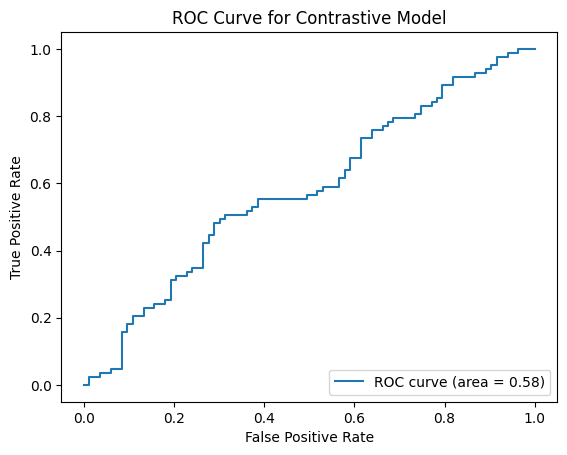

AUROC Score: 0.5802


In [120]:
# Evaluate the model
roc_auc = evaluate_contrastive_model(cs_bottle_MV, bottle_test_dataloader)
print(f"AUROC Score: {roc_auc:.4f}")

### Contrastive model for hazelnut

In [121]:
# Initialize and train the model
cs_hazelnut_MV = ContrastiveModel().to(DEVICE)
train_contrastive_model(cs_hazelnut_MV, hazelnut_train_dataloader, epochs=10)
torch.save(cs_hazelnut_MV.state_dict(), 'Contrastive_model_hazelnut_weights.pth')


Epoch 1/10: 100%|██████████| 25/25 [00:03<00:00,  7.62it/s]


Epoch [1/10] - Loss: 1.1197


Epoch 2/10: 100%|██████████| 25/25 [00:02<00:00,  8.39it/s]


Epoch [2/10] - Loss: 0.2544


Epoch 3/10: 100%|██████████| 25/25 [00:03<00:00,  8.06it/s]


Epoch [3/10] - Loss: 0.2514


Epoch 4/10: 100%|██████████| 25/25 [00:03<00:00,  8.18it/s]


Epoch [4/10] - Loss: 0.2503


Epoch 5/10: 100%|██████████| 25/25 [00:03<00:00,  7.94it/s]


Epoch [5/10] - Loss: 0.2514


Epoch 6/10: 100%|██████████| 25/25 [00:03<00:00,  8.12it/s]


Epoch [6/10] - Loss: 0.2501


Epoch 7/10: 100%|██████████| 25/25 [00:03<00:00,  8.04it/s]


Epoch [7/10] - Loss: 0.2508


Epoch 8/10: 100%|██████████| 25/25 [00:03<00:00,  7.75it/s]


Epoch [8/10] - Loss: 0.2504


Epoch 9/10: 100%|██████████| 25/25 [00:03<00:00,  8.28it/s]


Epoch [9/10] - Loss: 0.2501


Epoch 10/10: 100%|██████████| 25/25 [00:03<00:00,  8.31it/s]

Epoch [10/10] - Loss: 0.2504


100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


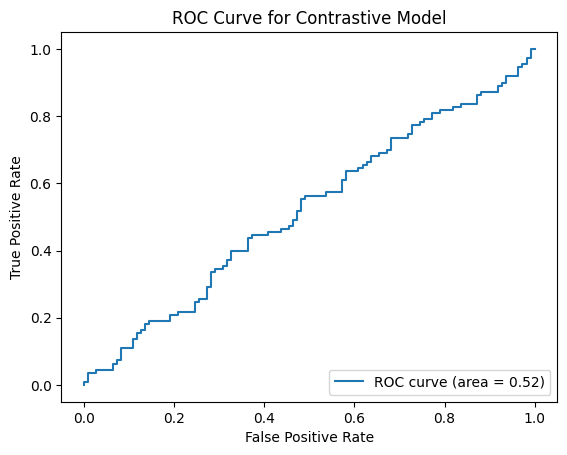

AUROC Score: 0.5185


In [122]:
# Evaluate the model
roc_auc = evaluate_contrastive_model(cs_hazelnut_MV, hazelnut_test_dataloader)
print(f"AUROC Score: {roc_auc:.4f}")

### Contrastive model for capsule

In [132]:
# Initialize and train the model
cs_capsule_MV = ContrastiveModel().to(DEVICE)
train_contrastive_model(cs_capsule_MV, capsule_train_dataloader, epochs=15)
torch.save(cs_capsule_MV.state_dict(), 'Contrastive_model_capsule_weights.pth')


Epoch 1/15: 100%|██████████| 14/14 [00:02<00:00,  6.98it/s]


Epoch [1/15] - Loss: 0.3000


Epoch 2/15: 100%|██████████| 14/14 [00:01<00:00,  8.43it/s]


Epoch [2/15] - Loss: 0.2550


Epoch 3/15: 100%|██████████| 14/14 [00:01<00:00,  8.46it/s]


Epoch [3/15] - Loss: 0.2527


Epoch 4/15: 100%|██████████| 14/14 [00:01<00:00,  8.23it/s]


Epoch [4/15] - Loss: 0.2494


Epoch 5/15: 100%|██████████| 14/14 [00:01<00:00,  8.44it/s]


Epoch [5/15] - Loss: 0.2536


Epoch 6/15: 100%|██████████| 14/14 [00:01<00:00,  8.08it/s]


Epoch [6/15] - Loss: 0.2514


Epoch 7/15: 100%|██████████| 14/14 [00:01<00:00,  8.04it/s]


Epoch [7/15] - Loss: 0.2523


Epoch 8/15: 100%|██████████| 14/14 [00:01<00:00,  8.52it/s]


Epoch [8/15] - Loss: 0.2492


Epoch 9/15: 100%|██████████| 14/14 [00:01<00:00,  8.52it/s]


Epoch [9/15] - Loss: 0.2516


Epoch 10/15: 100%|██████████| 14/14 [00:01<00:00,  8.43it/s]


Epoch [10/15] - Loss: 0.2521


Epoch 11/15: 100%|██████████| 14/14 [00:01<00:00,  8.32it/s]


Epoch [11/15] - Loss: 0.2525


Epoch 12/15: 100%|██████████| 14/14 [00:01<00:00,  8.38it/s]


Epoch [12/15] - Loss: 0.2493


Epoch 13/15: 100%|██████████| 14/14 [00:01<00:00,  8.43it/s]


Epoch [13/15] - Loss: 0.2535


Epoch 14/15: 100%|██████████| 14/14 [00:01<00:00,  8.46it/s]


Epoch [14/15] - Loss: 0.2521


Epoch 15/15: 100%|██████████| 14/14 [00:01<00:00,  8.22it/s]

Epoch [15/15] - Loss: 0.2506


100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


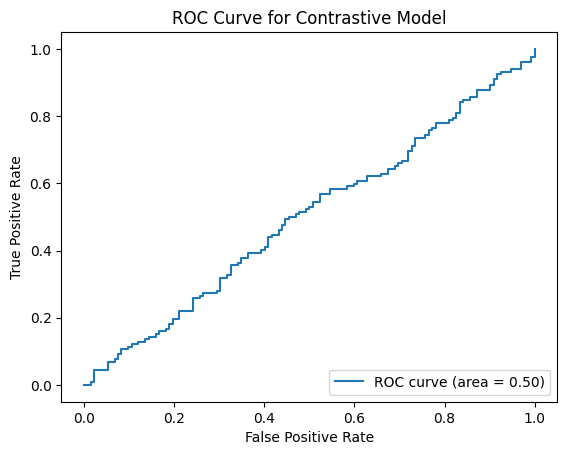

AUROC Score: 0.4990


In [133]:
# Evaluate the model
roc_auc = evaluate_contrastive_model(cs_capsule_MV, capsule_test_dataloader)
print(f"AUROC Score: {roc_auc:.4f}")

### Contrastive model for engine AutoVI 

In [124]:
cs_model_auto = ContrastiveModel().to(DEVICE)
train_contrastive_model(cs_model_auto, train_dataloader_auto, epochs=10)
torch.save(mae_model_auto.state_dict(), 'Contrastive_model_AUTO_weights.pth')

Epoch 1/10: 100%|██████████| 18/18 [00:02<00:00,  7.50it/s]


Epoch [1/10] - Loss: 0.4504


Epoch 2/10: 100%|██████████| 18/18 [00:02<00:00,  7.86it/s]


Epoch [2/10] - Loss: 0.2592


Epoch 3/10: 100%|██████████| 18/18 [00:02<00:00,  7.86it/s]


Epoch [3/10] - Loss: 0.2519


Epoch 4/10: 100%|██████████| 18/18 [00:02<00:00,  7.84it/s]


Epoch [4/10] - Loss: 0.2523


Epoch 5/10: 100%|██████████| 18/18 [00:02<00:00,  8.14it/s]


Epoch [5/10] - Loss: 0.2574


Epoch 6/10: 100%|██████████| 18/18 [00:02<00:00,  8.00it/s]


Epoch [6/10] - Loss: 0.2502


Epoch 7/10: 100%|██████████| 18/18 [00:02<00:00,  7.97it/s]


Epoch [7/10] - Loss: 0.2531


Epoch 8/10: 100%|██████████| 18/18 [00:02<00:00,  8.22it/s]


Epoch [8/10] - Loss: 0.2522


Epoch 9/10: 100%|██████████| 18/18 [00:02<00:00,  7.97it/s]


Epoch [9/10] - Loss: 0.2517


Epoch 10/10: 100%|██████████| 18/18 [00:02<00:00,  8.21it/s]


Epoch [10/10] - Loss: 0.2527


100%|██████████| 38/38 [00:05<00:00,  6.50it/s]


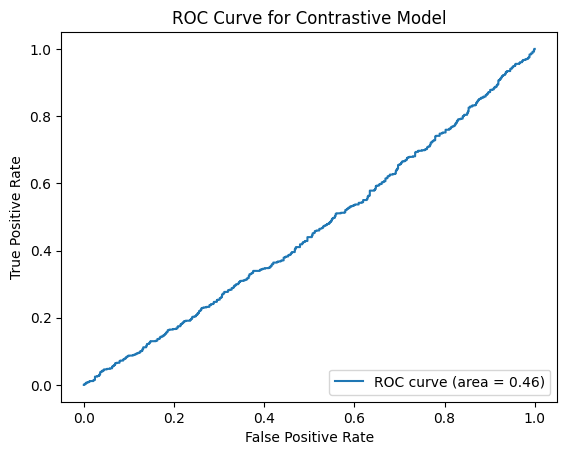

AUROC Score: 0.4602


In [125]:
roc_auc_score = evaluate_contrastive_model(cs_model_auto, test_dataloader_auto)
print(f"AUROC Score: {roc_auc_score:.4f}")

## Colorizing task

In [ ]:
## Other way to load data --> Choose together which one to keep
## This one allows you to train on data with no anomalies
## Keep in mind to evaluate the model with a test loader which contains anomalies
class MVTECDataset(Dataset):
    def __init__(self, data_dir="datasets/MVTec_AD/mvtec-ad", split="train", transform=TRANSFORM):
        self.data_dir = Path(data_dir)
        self.image_paths = []
        self.split = split
        self.transform = transform
        
        for folder in self.data_dir.iterdir():
            if folder.is_dir():
                folder_path = folder / self.split / "good"
                self.image_paths.extend(folder_path.rglob("*.png"))
            
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        # 0 because no anomaly
        label = 0
        
        return image, label
        
train_dataset_MVTEC = MVTECDataset()
print(f"Train dataset size: {len(train_dataset_MVTEC)}")

#test_dataset_MVTEC = MVTECDataset(split="test")
#print(f"Test dataset size: {len(test_dataset_MVTEC)}")

train_loader_MVTEC = DataLoader(train_dataset_MVTEC, batch_size=16, shuffle=True, num_workers=14, pin_memory=True)
#test_loader_MVTEC = DataLoader(test_dataset_MVTEC, batch_size=1, shuffle=False, num_workers=14, pin_memory=True)

### How to choose the right number of workers ?

In [ ]:
# Find the right number of workers
dataset = MVTECDataset()
for num_workers in range(2, mp.cpu_count(), 2):  
    train_loader = DataLoader(dataset, shuffle=False, num_workers=num_workers, batch_size=16, pin_memory=True)
    start = time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader, 0):
            pass
    end = time()
    print("Finish with: {} seconds, num_workers={}".format(end - start, num_workers))

### Build UNet

In [ ]:
## Lets choose a Unet to perform this task
def double_conv(in_channels, out_channels):
    # returns a block composed of two Convolution layers with ReLU activation function
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )   

class DownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x_skip = self.conv_block(x) # output after convolutions to be used for skip connection
        out = self.maxpool(x_skip)  # output after maxpooling for downsampling

        return out, x_skip

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, x_skip):
        x = self.upsample(x)
        x = torch.cat([x, x_skip], dim=1) # concatenate the upsampled output with skip connection
        x = self.conv_block(x)

        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Define downsampling blocks
        self.downsample_block_1 = DownSampleBlock(1, 32)
        self.downsample_block_2 = DownSampleBlock(32, 64)
        self.downsample_block_3 = DownSampleBlock(64, 128)
        self.middle_conv_block = double_conv(128, 256)  # Middle convolution block

        # Define upsampling blocks
        self.upsample_block_3 = UpSampleBlock(256 + 128, 128)
        self.upsample_block_2 = UpSampleBlock(128 + 64, 64)
        self.upsample_block_1 = UpSampleBlock(64 + 32, 32)

        # Final output layer
        self.last_conv = nn.Conv2d(32, 3, 1)

    def forward(self, x):
        # Convert to gray image
        x = rgb_to_grayscale(x, num_output_channels=1)
        
        # Downsampling path
        x, x_skip1 = self.downsample_block_1(x)
        x, x_skip2 = self.downsample_block_2(x)
        x, x_skip3 = self.downsample_block_3(x)

        # Middle block
        x = self.middle_conv_block(x)

        # Upsampling path with skip connections
        x = self.upsample_block_3(x, x_skip3)
        x = self.upsample_block_2(x, x_skip2)
        x = self.upsample_block_1(x, x_skip1)

        # Final output layer with sigmoid activation
        out = torch.sigmoid(self.last_conv(x))

        return out

### Training part

In [ ]:
unet = UNet().to(DEVICE)
train_model(model=unet, dataloader=train_loader_MVTEC, epochs=5)
torch.save(unet.state_dict(), 'Colorize_UNet_weights.pth')

### Evaluate the model

In [ ]:
roc_auc = evaluate_model(unet, test_dataloader_MVTec)
images, _ = next(iter(test_dataloader_MVTec))
images = images.to(DEVICE)
outputs = unet(images)

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,6))

# Original image
images = denormalize(images)
axs[0].imshow(np.clip(images[0].permute(1, 2, 0).detach().cpu().numpy(), 0, 1))
axs[0].set_title('Original')

# Reconstructed image
outputs = denormalize(outputs)
axs[1].imshow(np.clip(outputs[0].permute(1, 2, 0).detach().cpu().numpy(), 0, 1))
axs[1].set_title('Reconstructed')

plt.tight_layout()
plt.show()

## Note this doesn't work very well because of our dataset.. 
## Another idea to colorize images is described in this paper:
## https://ceur-ws.org/Vol-2485/paper47.pdf